Enter starting room number:  G07
Enter destination room number:  G27


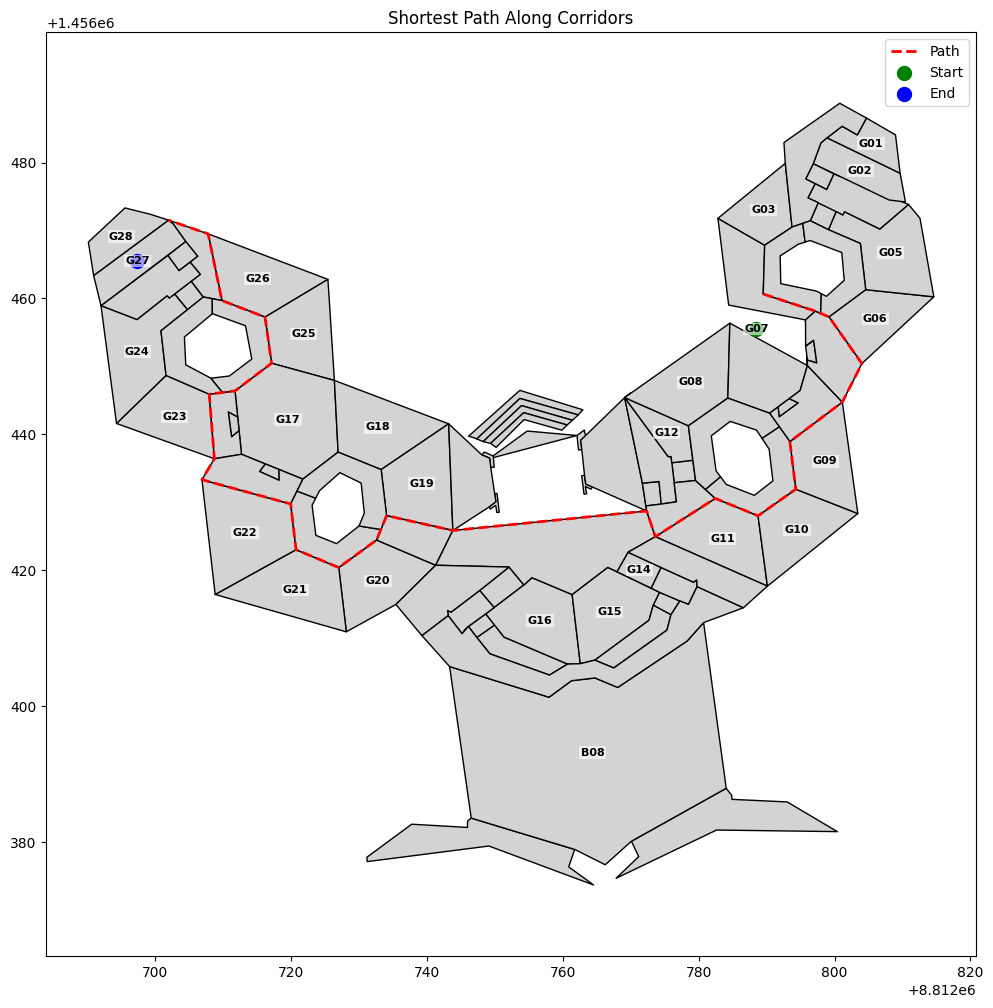

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import networkx as nx

# Load GeoJSON
gdf = gpd.read_file(r"C:\Users\Akshya\OneDrive\Desktop\DSA PROJECT\dsa-project (2)\dsa-project\prpc.geojson")

room_column = "Room_no."

# Split rooms and corridors
rooms = gdf[~gdf[room_column].str.startswith("C", na=False)]
corridors = gdf[gdf[room_column].str.startswith("C", na=False)]

# Ask for start/end rooms
start_room = input("Enter starting room number: ").strip()
end_room = input("Enter destination room number: ").strip()

start_geom = rooms[rooms[room_column] == start_room].geometry
end_geom = rooms[rooms[room_column] == end_room].geometry

if start_geom.empty or end_geom.empty:
    raise ValueError("❌ One of the rooms not found in data!")

start_centroid = start_geom.iloc[0].centroid
end_centroid = end_geom.iloc[0].centroid

# Convert corridors to boundary lines
corridor_lines = corridors.boundary

# Build corridor graph
G = nx.Graph()
for geom in corridor_lines:
    if geom.is_empty:
        continue
    if geom.geom_type == "LineString":
        coords = list(geom.coords)
        for i in range(len(coords) - 1):
            p1, p2 = Point(coords[i]), Point(coords[i + 1])
            G.add_edge((p1.x, p1.y), (p2.x, p2.y), weight=p1.distance(p2))
    elif geom.geom_type == "MultiLineString":
        for part in geom.geoms:
            coords = list(part.coords)
            for i in range(len(coords) - 1):
                p1, p2 = Point(coords[i]), Point(coords[i + 1])
                G.add_edge((p1.x, p1.y), (p2.x, p2.y), weight=p1.distance(p2))

# Snap room centroid to nearest corridor node 
def connect_to_corridor(point):
    nearest = None
    min_dist = float("inf")
    for node in G.nodes:
        node_point = Point(node)
        d = point.distance(node_point)
        if d < min_dist:
            min_dist = d
            nearest = node
    return nearest

start_node = connect_to_corridor(start_centroid)
end_node = connect_to_corridor(end_centroid)

if start_node is None or end_node is None:
    raise ValueError("❌ Could not snap start or end room to any corridor!")

# Shortest path along corridors
if nx.has_path(G, start_node, end_node):
    path_coords = nx.shortest_path(G, source=start_node, target=end_node, weight="weight")
else:
    # No path exists, duplicate start node to make a line
    path_coords = [start_node]

# Ensure LineString has at least 2 points
if len(path_coords) < 2:
    x, y = path_coords[0]
    offset = 0.1  # small offset so the line is visible
    path_coords.append((x + offset, y + offset))

path_line = LineString(path_coords)

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot rooms and corridors
gdf.plot(ax=ax, color="lightgrey", edgecolor="black")

# Draw shortest path
x, y = path_line.xy
ax.plot(x, y, color="red", linewidth=2, linestyle="--", label="Path")

# Mark start and end rooms
ax.scatter(start_centroid.x, start_centroid.y, color="green", s=100, label="Start")
ax.scatter(end_centroid.x, end_centroid.y, color="blue", s=100, label="End")

# Add room numbers on top of polygons
for _, row in gdf.iterrows():
    geom = row.geometry
    if geom.is_empty:
        continue
    c = geom.centroid
    if row[room_column] and not str(row[room_column]).startswith("C"):
        ax.text(
            c.x, c.y, str(row[room_column]),
            fontsize=8, fontweight="bold", color="black",
            ha="center", va="center",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1)
        )

ax.legend()
plt.title("Shortest Path Along Corridors")
plt.axis("equal")
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import networkx as nx

# Load GeoJSON
gdf = gpd.read_file(r"C:\Users\Akshya\OneDrive\Desktop\DSA PROJECT\dsa-project (2)\dsa-project\prpc.geojson")

room_column = "Room_no."

# Split rooms and corridors
rooms = gdf[~gdf[room_column].str.startswith("C", na=False)]
corridors = gdf[gdf[room_column].str.startswith("C", na=False)]

# Ask for start/end rooms
start_room = input("Enter starting room number: ").strip()
end_room = input("Enter destination room number: ").strip()

start_geom = rooms[rooms[room_column] == start_room].geometry
end_geom = rooms[rooms[room_column] == end_room].geometry

if start_geom.empty or end_geom.empty:
    raise ValueError("❌ One of the rooms not found in data!")

start_centroid = start_geom.iloc[0].centroid
end_centroid = end_geom.iloc[0].centroid

# Convert corridors to boundary lines
corridor_lines = corridors.boundary

# Build corridor graph
G = nx.Graph()
for geom in corridor_lines:
    if geom.is_empty:
        continue
    if geom.geom_type == "LineString":
        coords = list(geom.coords)
        for i in range(len(coords) - 1):
            p1, p2 = Point(coords[i]), Point(coords[i + 1])
            G.add_edge((p1.x, p1.y), (p2.x, p2.y), weight=p1.distance(p2))
    elif geom.geom_type == "MultiLineString":
        for part in geom.geoms:
            coords = list(part.coords)
            for i in range(len(coords) - 1):
                p1, p2 = Point(coords[i]), Point(coords[i + 1])
                G.add_edge((p1.x, p1.y), (p2.x, p2.y), weight=p1.distance(p2))

# Snap room centroid to nearest corridor node 
def connect_to_corridor(point):
    nearest = None
    min_dist = float("inf")
    for node in G.nodes:
        node_point = Point(node)
        d = point.distance(node_point)
        if d < min_dist:
            min_dist = d
            nearest = node
    return nearest

start_node = connect_to_corridor(start_centroid)
end_node = connect_to_corridor(end_centroid)

if start_node is None or end_node is None:
    raise ValueError("❌ Could not snap start or end room to any corridor!")

# Shortest path along corridors
if nx.has_path(G, start_node, end_node):
    path_coords = nx.shortest_path(G, source=start_node, target=end_node, weight="weight")
else:
    # No path exists, duplicate start node to make a line
    path_coords = [start_node]

# Ensure LineString has at least 2 points
if len(path_coords) < 2:
    x, y = path_coords[0]
    offset = 0.1  # small offset so the line is visible
    path_coords.append((x + offset, y + offset))

path_line = LineString(path_coords)

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot rooms and corridors
gdf.plot(ax=ax, color="lightgrey", edgecolor="black")

# Draw shortest path
x, y = path_line.xy
ax.plot(x, y, color="red", linewidth=2, linestyle="--", label="Path")

# Mark start and end rooms
ax.scatter(start_centroid.x, start_centroid.y, color="green", s=100, label="Start")
ax.scatter(end_centroid.x, end_centroid.y, color="blue", s=100, label="End")

# Add room numbers on top of polygons
for _, row in gdf.iterrows():
    geom = row.geometry
    if geom.is_empty:
        continue
    c = geom.centroid
    if row[room_column] and not str(row[room_column]).startswith("C"):
        ax.text(
            c.x, c.y, str(row[room_column]),
            fontsize=8, fontweight="bold", color="black",
            ha="center", va="center",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1)
        )

ax.legend()
plt.title("Shortest Path Along Corridors")
plt.axis("equal")
plt.show()